In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
from zipfile import ZipFile


os.makedirs('data', exist_ok=True)
os.chdir('..')
source_path = "content/drive/Othercomputers/My Laptop/RP/data/CSCD.zip"
destination_path = "content/data/CSCD.zip"

shutil.copy(source_path, destination_path)

with ZipFile(destination_path, 'r') as zip_ref:
    zip_ref.extractall("content/data")

print("File copied and unpacked successfully.")

File copied and unpacked successfully.


In [3]:
os.chdir(os.path.join("content", "drive", "Othercomputers", "My Laptop", "RP", "urban-change-detection"))

In [4]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 27.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cac

#### Imports


In [5]:
import argparse
import sys
from importlib import reload

sys.path.insert(1, 'siamese_fcn')
sys.path.insert(1, 'datasets')
sys.path.insert(1, 'evaluation')
sys.path.insert(1, 'results')
sys.path.insert(1, 'visualization')
sys.path.insert(1, 'util')

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import metrics
from metrics import evaluate_net_predictions
from tables import create_tables
from plots import create_figures
from tqdm import tqdm as tqdm
from preprocess_util import reshape_for_torch
from unet import Unet
from siamunet_conc import SiamUnet_conc
from siamunet_diff import SiamUnet_diff
from fresunet import FresUNet
import train_test
import cscd_dataset_loader
reload(cscd_dataset_loader)
from levir_dataset_loader import LEVIR_Dataset
from hrscd_dataset_loader import HRSCD_Dataset
from cscd_dataset_loader import CSCD_Dataset
from late_siam_net import SiamLateFusion
import time


#### Load Data

In [6]:
N_EPOCHS = 10
FP_MODIFIER = 1
BATCH_SIZE = 64
TEST_RUN = False
RELATIVE_TO_CSCD = os.path.join('..', '..', '..',  '..', '..')
# DIRNAME_CSCD = os.path.join(RELATIVE_TO_CSCD, "data")
DIRNAME_CSCD = os.path.join(RELATIVE_TO_CSCD, "data")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# train_dataset_levir = LEVIR_Dataset(DIRNAME, "train")
# test_dataset_levir = LEVIR_Dataset(DIRNAME, "test")
# val_dataset_levir  = LEVIR_Dataset(DIRNAME, "val")

# train_dataset_hrscd = HRSCD_Dataset(DIRNAME, "train")
# test_dataset_hrscd = HRSCD_Dataset(DIRNAME, "test")
# val_dataset_hrscd = HRSCD_Dataset(DIRNAME, "val")

FP_MODIFIER = 10

train_dataset_cscd = CSCD_Dataset(DIRNAME_CSCD, "train", FP_MODIFIER)
test_dataset_cscd = CSCD_Dataset(DIRNAME_CSCD, "test", FP_MODIFIER)
val_dataset_cscd = CSCD_Dataset(DIRNAME_CSCD, "val", FP_MODIFIER)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = torch.FloatTensor(train_dataset_cscd.weights).to(device)
print(weights)

tensor([0.8532, 1.9147], device='cuda:0')


In [8]:
next(iter(train_dataset_cscd))

{'I1': tensor([[[255, 255, 255,  ...,   0,   0,   0],
          [255, 255, 255,  ...,   0,   0,   0],
          [255, 255, 255,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255]],
 
         [[255, 255, 255,  ..., 128, 128, 128],
          [255, 255, 255,  ..., 128, 128, 128],
          [255, 255, 255,  ..., 128, 128, 128],
          ...,
          [128, 128, 128,  ..., 255, 255, 255],
          [128, 128, 128,  ..., 255, 255, 255],
          [128, 128, 128,  ..., 255, 255, 255]],
 
         [[  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]]], dtype=torch.uint8),
 'I2': tensor([[[255, 255, 255,  ...,   0,   0,   0],
   

In [ ]:


train_loader = DataLoader(train_dataset_cscd, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
test_loader = DataLoader(test_dataset_cscd, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset_cscd, batch_size = BATCH_SIZE, shuffle = True, num_workers = 4)

# net, net_name = Unet(3, 2), 'Early-Fusion'
net, net_name = SiamUnet_conc(3, 2), 'Mid-Conc-Fusion'
# net, net_name = SiamUnet_diff(3, 2), 'Mid-Diff-Fusion'
# net, net_name = SiamLateFusion(3, 2), 'Late-Fusion'
net.to(device)

criterion = nn.NLLLoss(weight=weights)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
reload(train_test)
reload(metrics)
from train_test import train

save_dir = f'{net_name}-{time.time()}.pth.tar'
training_metrics, validation_metrics  = train(net, train_dataset_cscd, train_loader, val_dataset_cscd, criterion, device, n_epochs= 2, save=True, save_dir = save_dir, skip_val = False)

Epoch 1/2: 100%|██████████| 64/64 [00:17<00:00,  3.72batch/s, loss=0.138]


ValueError: too many values to unpack (expected 4)

In [ ]:
from data_examination import examine_subset

examine_subset(net, net_name, test_dataset_cscd, 10, device)

In [ ]:
reload(metrics)
from metrics import evaluate_net_predictions
test_metrics = evaluate_net_predictions(net, criterion, test_dataset_cscd)

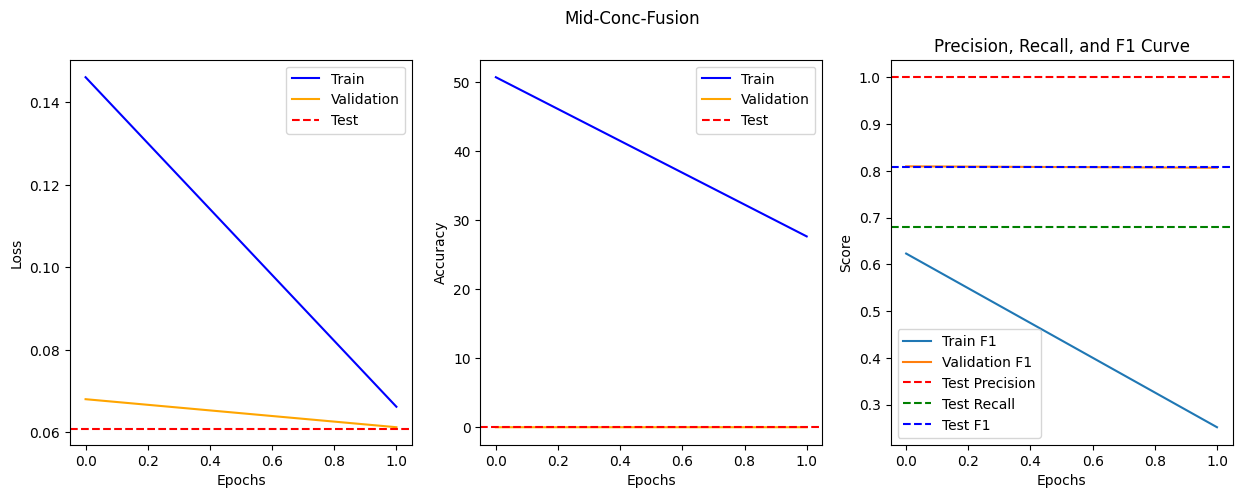

In [ ]:
import tables
import plots
reload(tables)
reload(plots)
from tables import create_tables
from plots import create_figures


create_figures(training_metrics, validation_metrics, test_metrics, net_name)
# create_tables(training_metrics, validation_metrics, test_metrics, net_name)

In [ ]:
# import torch
# from torch.autograd import Variable
# from tqdm import tqdm as tqdm
# import numpy as np
# import cv2

# IOU_THRESHOLD = 0.5


# def evaluate_net_prediction_batch(predictions, ground_truths, IOU_THRESHOLD=0.5):
#     predictions = predictions.cpu().detach().numpy()
#     ground_truths = ground_truths.cpu().detach().numpy()

#     batch_size = predictions.shape[0]

#     results = [0, 0, 0, 0]

#     for i in range(batch_size):
#         prediction = predictions[i]
#         ground_truth = ground_truths[i]

#         predicted =  np.exp(np.squeeze(prediction)[1])
#         predicted = np.where(predicted < 0.5, 0, 1)

#         ground_truth = np.squeeze(ground_truth)
#         ground_truth = (ground_truth - np.min(ground_truth)) / (np.ptp(ground_truth)) if np.ptp(ground_truth) != 0 else np.zeros_like(ground_truth)

#         pr = np.where(predicted > 0.5, 1, 0)
#         gt = np.where(ground_truth > 0.5, 1, 0)

#         pr = pr.flatten()
#         gt = gt.flatten()

#         tp_img = np.sum(pr & gt)
#         tn_img = np.sum(~pr & ~gt)
#         fp_img = np.sum(pr & ~gt)
#         fn_img = np.sum(~pr & gt)

#         iou = tp_img / max(tp_img + fn_img + fp_img, 1e-10)
#         no_object = tp_img + fn_img == 0

#         result = None

#         if iou >= min(IOU_THRESHOLD, 1):
#             result = [1, 0, 0, 0] #tp
#         elif iou > 0 and no_object:
#             results = [0, 1, 0, 0] #fp
#         elif iou < IOU_THRESHOLD and no_object:
#             result = [0, 0, 1, 0] #tn
#         elif iou < IOU_THRESHOLD and (not no_object):
#             result = [0, 0, 0, 1] #fn

#         else:
#             raise ValueError('You shoudn\'t be here')

#         results = np.add(results, result)



#     batch_accuracy = 100 * (results[0] + results[2]) / batch_size
#     prec = results[0] / max(1, (results[0] + results[1]))
#     rec = results[0] / max(1, (results[0] + results[3]))


#     return {'batch_accuracy': batch_accuracy,
#             'precision': prec,
#             'recall': rec}


# def evaluate_net_predictions(net, criterion, dataset):
#     net.eval()
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     net.to(device)

#     tp = 0
#     tn = 0
#     fp = 0
#     fn = 0

#     tot_loss = 0
#     tot_count = 0

#     for img_index in dataset.names:
#         I1, I2, cm, _ = dataset.get_img(img_index)

#         I1 = Variable(torch.unsqueeze(I1, 0).float().to(device))
#         I2 = Variable(torch.unsqueeze(I2, 0).float().to(device))
#         cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).long().to(device))

#         output = net(I1, I2).float().to(device)

#         loss = criterion(output, cm)
#         tot_loss += loss.data * np.prod(cm.size())
#         tot_count += np.prod(cm.size())

#         predicted =  np.exp(np.squeeze(output.cpu().detach().numpy())[1])
#         predicted = np.where(predicted < 0.5, 0, 1)

#         cm = np.squeeze(cm.cpu().detach().numpy())
#         cm = (cm - np.min(cm)) / (np.ptp(cm)) if np.ptp(cm) != 0 else np.zeros_like(cm)
#         gt = np.where(cm > 0.5, 1, 0)

#         pr = predicted.flatten()
#         gt = gt.flatten()



#         tp_img = np.sum(pr & gt)
#         tn_img = np.sum(~pr & ~gt)
#         fp_img = np.sum(pr & ~gt)
#         fn_img = np.sum(~pr & gt)

#         iou = tp_img / max(tp_img + fn_img + fp_img, 1e-10)
#         # print(iou)
#         no_object = tp_img + fn_img == 0

#         if iou >= min(IOU_THRESHOLD, 1):
#             tp += 1
#         if iou > 0 and no_object:
#             fp += 1
#         if iou < IOU_THRESHOLD and (not no_object):
#             fn += 1
#         if iou < IOU_THRESHOLD and no_object:
#             tn += 1


#     net_loss = tot_loss/tot_count
#     net_loss = float(net_loss.cpu().numpy())

#     net_accuracy = 100 * (tp + tn)/tot_count


#     prec = tp / max(1, (tp + fp))
#     rec = tp / max(1, (tp + fn))


#     return {'net_loss': net_loss,
#             'net_accuracy': net_accuracy,
#             'precision': prec,
#             'recall': rec}

# def cluster_image_colors(img, categories):
#     Z = img.reshape((-1,3))
#     Z = np.float32(Z)
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
#     K = len(categories)
#     _, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
#     center = np.uint8(center)
#     res = center[label.flatten()]
#     out = res.reshape((img.shape))

#     return out

# def map_to_categorical(img):
#     vals = np.sort(np.unique(img))

#     value_to_position = {value: index for index, value in enumerate(vals)}

#     # Assumes img is one dimensional
#     positions = np.vectorize(value_to_position.get)(np.ndarray.flatten(img))

#     return positions.reshape(img.shape)


# def evaluate_img_categorically(y, y_hat, y_category, categories):


#     out = {c: [0, 0, 0, 0] for c in categories}
#     y_category = y_category[:, :, 0].astype(int)


#     for c in categories:
#         mask = y_category == categories.index(c)  # Create a mask for the current category


#         tp = np.sum((y == 1) & (y_hat == 1) & mask)
#         fp = np.sum((y == 1) & (y_hat == 0) & mask)
#         tn = np.sum((y == 0) & (y_hat == 0) & mask)
#         fn = np.sum((y == 0) & (y_hat == 1) & mask)

#         iou = tp / max(tp + fn + fp, 1e-10)
#         no_object = tp + fn == 0

#         if iou >= min(IOU_THRESHOLD, 1):
#             out[c] = [1, 0, 0, 0] #tp
#         if iou > 0 and no_object:
#             out[c] = [0, 1, 0, 0] #fp
#         if iou < IOU_THRESHOLD and no_object:
#             out[c] = [0, 0, 1, 0] #tn
#         if iou < IOU_THRESHOLD and (not no_object):
#             out[c] = [0, 0, 0, 1]  #fn


#     return out


# def evaluate_categories(net, dataset_name, dataset, categories):

#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     net.to(device)

#     categorical_metrics = {}

#     for c in categories:
#         categorical_metrics[c] = [0, 0, 0, 0] #tp, fp, tn,  fn

#     index = 0

#     for img_index in dataset.names:
#         index += 1

#         if dataset_name is "CSCD":
#             I1, I2, cm, situation = dataset.get_img(img_index)
#             # categorical = np.divide(cv2.cvtColor(cm, cv2.COLOR_GRAY2RGB), 255)
#             categorical = np.multiply(cm, categories.index(situation))
#             categorical = np.expand_dims(categorical, axis=0)
#             # print(categorical.shape)


#         elif dataset_name in ["HRSCD", "HIUCD"]:
#             I1, I2, cm, categorical = dataset.get_img(img_index)
#             categorical = cluster_image_colors(categorical, categories)

#             categorical = map_to_categorical(categorical)
#         else:
#             print('Not a categorical dataset')
#             break


#         I1 = Variable(torch.unsqueeze(I1, 0).float().to(device))
#         I2 = Variable(torch.unsqueeze(I2, 0).float().to(device))

#         cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).long().to(device))


#         output = net(I1, I2).float().to(device)

#         _, predicted = torch.max(output.data, 1)


#         predicted = np.squeeze(output.cpu().detach().numpy())[0] -np.squeeze(output.cpu().detach().numpy())[1]
#         predicted = (predicted - np.min(predicted)) / (np.max(predicted) - np.min(predicted))
#         cm = np.squeeze(cm.cpu().detach().numpy())
#         cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))
#         predicted = np.where(predicted < 0.5, 0, 1)
#         cm = np.where(cm < 0.5, 0, 1)

#         curr_metrics = evaluate_img_categorically(cm, predicted, categorical, categories)

#         for c in categories:
#             categorical_metrics[c] = np.add(categorical_metrics[c], curr_metrics[c])



#     return categorical_metrics


import torch
from torch.autograd import Variable
from tqdm import tqdm as tqdm
import numpy as np
import cv2

IOU_THRESHOLD = 0.5


def evaluate_net_prediction_batch(predictions, ground_truths, IOU_THRESHOLD=0.5):
    predictions = predictions.cpu().detach().numpy()
    ground_truths = ground_truths.cpu().detach().numpy()

    batch_size = predictions.shape[0]

    results = [0, 0, 0, 0]

    for i in range(batch_size):
        prediction = predictions[i]
        ground_truth = ground_truths[i]

        predicted =  np.exp(np.squeeze(prediction)[1])
        predicted = np.where(predicted < 0.5, 0, 1)

        ground_truth = np.squeeze(ground_truth)
        ground_truth = (ground_truth - np.min(ground_truth)) / (np.ptp(ground_truth)) if np.ptp(ground_truth) != 0 else np.zeros_like(ground_truth)

        pr = np.where(predicted > 0.5, 1, 0)
        gt = np.where(ground_truth > 0.5, 1, 0)

        pr = pr.flatten()
        gt = gt.flatten()

        tp_img = np.sum(pr & gt)
        tn_img = np.sum(~pr & ~gt)
        fp_img = np.sum(pr & ~gt)
        fn_img = np.sum(~pr & gt)

        iou = tp_img / max(tp_img + fn_img + fp_img, 1e-10)
        no_object = tp_img + fn_img == 0

        result = None

        if iou >= min(IOU_THRESHOLD, 1):
            result = [1, 0, 0, 0] #tp
        elif iou > 0 and no_object:
            results = [0, 1, 0, 0] #fp
        elif iou < IOU_THRESHOLD and no_object:
            result = [0, 0, 1, 0] #tn
        elif iou < IOU_THRESHOLD and (not no_object):
            result = [0, 0, 0, 1] #fn

        else:
            raise ValueError('You shoudn\'t be here')

        results = np.add(results, result)



    batch_accuracy = 100 * (results[0] + results[2]) / batch_size
    prec = results[0] / max(1, (results[0] + results[1]))
    rec = results[0] / max(1, (results[0] + results[3]))


    return {'batch_accuracy': batch_accuracy,
            'precision': prec,
            'recall': rec}


def evaluate_net_predictions(net, criterion, dataset):
    net.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    tp = 0
    tn = 0
    fp = 0
    fn = 0

    tot_loss = 0
    tot_count = 0

    for img_index in dataset.names:
        I1, I2, cm, _ = dataset.get_img(img_index)

        I1 = Variable(torch.unsqueeze(I1, 0).float().to(device))
        I2 = Variable(torch.unsqueeze(I2, 0).float().to(device))
        cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).long().to(device))

        output = net(I1, I2).float().to(device)

        loss = criterion(output, cm)
        tot_loss += loss.data * np.prod(cm.size())
        tot_count += np.prod(cm.size())

        predicted =  np.exp(np.squeeze(output.cpu().detach().numpy())[1])
        predicted = np.where(predicted < 0.5, 0, 1)

        cm = np.squeeze(cm.cpu().detach().numpy())
        cm = (cm - np.min(cm)) / (np.ptp(cm)) if np.ptp(cm) != 0 else np.zeros_like(cm)
        gt = np.where(cm > 0.5, 1, 0)

        pr = predicted.flatten()
        gt = gt.flatten()



        tp_img = np.sum(pr & gt)
        tn_img = np.sum(~pr & ~gt)
        fp_img = np.sum(pr & ~gt)
        fn_img = np.sum(~pr & gt)

        iou = tp_img / max(tp_img + fn_img + fp_img, 1e-10)
        # print(iou)
        no_object = tp_img + fn_img == 0

        if iou >= min(IOU_THRESHOLD, 1):
            tp += 1
        if iou > 0 and no_object:
            fp += 1
        if iou < IOU_THRESHOLD and (not no_object):
            fn += 1
        if iou < IOU_THRESHOLD and no_object:
            tn += 1


    net_loss = tot_loss/tot_count
    net_loss = float(net_loss.cpu().numpy())

    net_accuracy = 100 * (tp + tn)/tot_count


    prec = tp / max(1, (tp + fp))
    rec = tp / max(1, (tp + fn))


    return {'net_loss': net_loss,
            'net_accuracy': net_accuracy,
            'precision': prec,
            'recall': rec}

def cluster_image_colors(img, categories):
    Z = img.reshape((-1,3))
    Z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = len(categories)
    _, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    out = res.reshape((img.shape))

    return out

def map_to_categorical(img):
    vals = np.sort(np.unique(img))

    value_to_position = {value: index for index, value in enumerate(vals)}

    # Assumes img is one dimensional
    positions = np.vectorize(value_to_position.get)(np.ndarray.flatten(img))

    return positions.reshape(img.shape)


def evaluate_img_categorically(y, y_hat, num_changes, y_category, categories):


    out = {c: [0, 0, 0, 0] for c in categories}


    num_changes_predicted = len(cv2.findContours(cv2.cvtColor(y_hat.copy(), cv2.COLOR_BGR2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE))
    out['num_changes'] = [num_changes, num_changes_predicted]

    y_category = y_category[:, :, 0].astype(int)

    for c in categories:

        mask = y_category == categories.index(c)  # Create a mask for the current category


        tp = np.sum((y == 1) & (y_hat == 1) & mask)
        fp = np.sum((y == 1) & (y_hat == 0) & mask)
        tn = np.sum((y == 0) & (y_hat == 0) & mask)
        fn = np.sum((y == 0) & (y_hat == 1) & mask)

        iou = tp / max(tp + fn + fp, 1e-10)
        no_object = tp + fn == 0

        if iou >= min(IOU_THRESHOLD, 1):
            out[c] = [1, 0, 0, 0] #tp
        if iou > 0 and no_object:
            out[c] = [0, 1, 0, 0] #fp
        if iou < IOU_THRESHOLD and no_object:
            out[c] = [0, 0, 1, 0] #tn
        if iou < IOU_THRESHOLD and (not no_object):
            out[c] = [0, 0, 0, 1]  #fn


    return out


def evaluate_categories(net, dataset_name, dataset, categories):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    categorical_metrics = {}

    for c in categories:
        categorical_metrics[c] = [0, 0, 0, 0] #tp, fp, tn,  fn

    categorical_metrics['num_changes'] = []

    index = 0

    num_changes = 0

    for img_index in dataset.names:
        index += 1

        if dataset_name is "CSCD":
            I1, I2, cm, situation, num_changes = dataset.get_img(img_index)
            # categorical = np.divide(cv2.cvtColor(cm, cv2.COLOR_GRAY2RGB), 255)
            categorical = np.multiply(cm, categories.index(situation))
            categorical = np.expand_dims(categorical, axis=0)
            print(categorical.shape)


        elif dataset_name in ["HRSCD", "HIUCD"]:
            I1, I2, cm, categorical = dataset.get_img(img_index)
            num_changes = len(cv2.findContours(cv2.cvtColor(cm.copy(), cv2.COLOR_BGR2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE))
            categorical = cluster_image_colors(categorical, categories)

            categorical = map_to_categorical(categorical)
        else:
            print('Not a categorical dataset')
            break


        I1 = Variable(torch.unsqueeze(I1, 0).float().to(device))
        I2 = Variable(torch.unsqueeze(I2, 0).float().to(device))

        cm = Variable(torch.unsqueeze(torch.from_numpy(1.0*cm),0).long().to(device))


        output = net(I1, I2).float().to(device)

        _, predicted = torch.max(output.data, 1)


        predicted = np.exp(np.squeeze(output.cpu().detach().numpy())[1])
        cm = np.squeeze(cm.cpu().detach().numpy())
        cm = (cm - np.min(cm)) / (np.max(cm) - np.min(cm))
        predicted = np.where(predicted < 0.5, 0, 1)
        cm = np.where(cm < 0.5, 0, 1)

        curr_metrics = evaluate_img_categorically(cm, predicted, num_changes, categorical, categories)

        for c in categories:
            categorical_metrics[c] = np.add(categorical_metrics[c], curr_metrics[c])
        categorical_metrics['num_changes'].append(curr_metrics['num_changes'])



    return categorical_metrics




<>:478: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:478: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-18-f13ef0deaa01>:478: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dataset_name is "CSCD":


In [ ]:
# import metrics
# reload(metrics)
# from metrics import evaluate_categories

categorical_metrics = evaluate_categories(net, "CSCD", test_dataset_cscd, ["large_change_uniform", "large_change_non_uniform", "small_change_non_uniform", "small_change_uniform"])

ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
from plots import category_histograms


category_histograms('Middle-Fusion-Conc.', 'Categorical Eval', categorical_metrics )